## EDA

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation, linear_model
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn import datasets
import random
import time

In [ ]:
import firebase_admin
from firebase_admin import credentials

cred = credentials.Certificate("./Firebase/serviceAccountKey.json")
firebase_admin.initialize_app(cred)

In [3]:
df = pd.read_parquet('https://console.firebase.google.com/project/music-reco-c4de1/storage/music-reco-c4de1.appspot.com/files/user_track_df.parquet', engine='pyarrow')
df.head()

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,...,-8.176,0,0.0327,0.11900,0.000412,0.103,0.0396,126.051,4,4ssUf5gLb1GBLxi1BhPrVt
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,...,-12.640,1,0.0355,0.46800,0.000043,0.117,0.4430,122.012,4,3GBPw9NK25X1Wt2OUvOwY3
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEWFWM12A8C1308BA,1,TRLQPQJ128F42AA94F,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,...,-12.321,0,0.0653,0.29700,0.000267,0.127,0.9050,114.656,4,3jc496ljiyrS3ECrD7QiqL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11793648 entries, 0 to 11793647
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   song_id           object 
 2   listen_count      int64  
 3   track_id          object 
 4   artist_name       object 
 5   track_name        object 
 6   track_uri         object 
 7   popularity        int64  
 8   duration_ms       int64  
 9   explicit          int64  
 10  release_date      object 
 11  danceability      float64
 12  energy            float64
 13  key               int64  
 14  loudness          float64
 15  mode              int64  
 16  speechiness       float64
 17  acousticness      float64
 18  instrumentalness  float64
 19  liveness          float64
 20  valence           float64
 21  tempo             float64
 22  time_signature    int64  
 23  artist_id         object 
dtypes: float64(9), int64(7), object(8)
memory usage: 2.1+ GB


In [5]:
df.describe()

,listen_count,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07,1.179365e+07
mean,2.893217e+00,5.773708e+01,2.434003e+05,8.264695e-02,5.704806e-01,6.731045e-01,5.344402e+00,-7.795270e+00,6.637429e-01,6.446345e-02,1.990057e-01,7.478830e-02,1.879835e-01,5.276782e-01,1.219446e+02,3.942510e+00
std,5.825543e+00,1.493103e+01,6.617471e+04,2.753478e-01,1.586017e-01,2.134814e-01,3.572843e+00,3.714323e+00,4.724281e-01,6.526362e-02,2.662737e-01,2.024800e-01,1.451038e-01,2.447332e-01,2.772366e+01,2.748971e-01
min,1.000000e+00,0.000000e+00,3.082700e+04,0.000000e+00,0.000000e+00,2.030000e-05,0.000000e+00,-3.765800e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,4.800000e+01,2.054530e+05,0.000000e+00,4.620000e-01,5.300000e-01,2.000000e+00,-9.502000e+00,0.000000e+00,3.240000e-02,6.200000e-03,0.000000e+00,9.340000e-02,3.220000e-01,1.001580e+02,4.000000e+00
50%,1.000000e+00,5.800000e+01,2.359330e+05,0.000000e+00,5.770000e-01,7.070000e-01,5.000000e+00,-6.981000e+00,1.000000e+00,4.120000e-02,6.750000e-02,6.470000e-05,1.250000e-01,5.350000e-01,1.203360e+02,4.000000e+00
75%,3.000000e+00,6.900000e+01,2.721330e+05,0.000000e+00,6.810000e-01,8.470000e-01,9.000000e+00,-5.201000e+00,1.000000e+00,6.460000e-02,2.920000e-01,8.080000e-03,2.580000e-01,7.260000e-01,1.399690e+02,4.000000e+00
max,2.213000e+03,8.600000e+01,1.777907e+06,1.000000e+00,9.800000e-01,9.990000e-01,1.100000e+01,5.376000e+00,1.000000e+00,9.580000e-01,9.960000e-01,9.880000e-01,9.970000e-01,9.920000e-01,2.433720e+02,5.000000e+00


In [6]:
df.duplicated().any()

False

In [7]:
df.isnull().values.any()

False

In [8]:
df.eq(0).sum()

user_id                    0
song_id                    0
listen_count               0
track_id                   0
artist_name                0
track_name                 0
track_uri                  0
popularity              4013
duration_ms                0
explicit            10818939
release_date               0
danceability               3
energy                     0
key                  1324577
loudness                   0
mode                 3965698
speechiness                3
acousticness              95
instrumentalness     3446578
liveness                   0
valence                    3
tempo                      3
time_signature             3
artist_id                  0
dtype: int64

In [9]:
songs = df['song_id'].unique()
len(songs) ## return 19827 unique songs

19827

In [10]:
users = df['user_id'].unique()
len(users) ## return 983357 unique users

983357

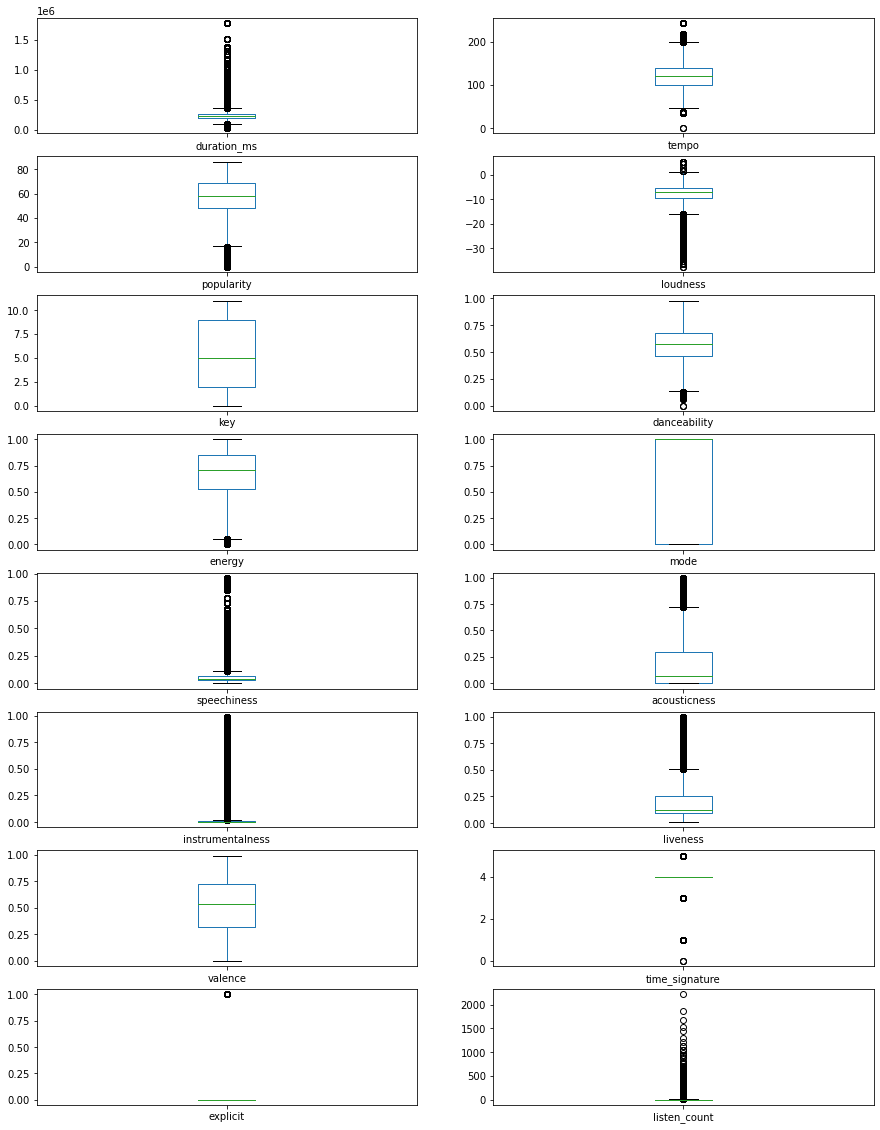

In [11]:
#define number of rows and columns for subplots
nrow=8
ncol=2

# make a list of all columns
df_list = [df['duration_ms'], df['tempo'], df['popularity'], df['loudness'],
          df['key'], df['danceability'], df['energy'], df['mode'], df['speechiness'],
          df['acousticness'], df['instrumentalness'], df['liveness'], df['valence'],
          df['time_signature'], df['explicit'], df['listen_count']]
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot.box(ax=axes[r,c], figsize=(15,20))
        count+=1

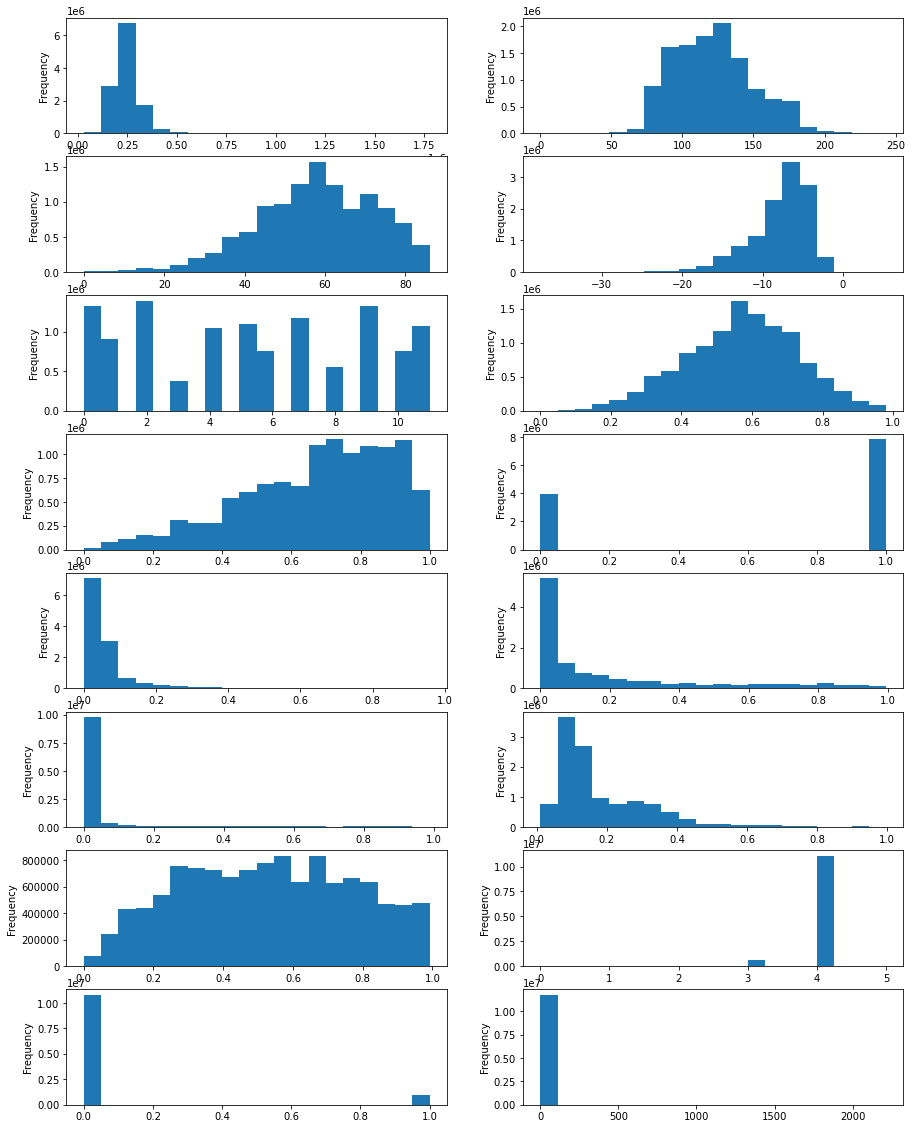

In [12]:
#define number of rows and columns for subplots
nrow=8
ncol=2

# make a list of all columns
df_list = [df['duration_ms'], df['tempo'], df['popularity'], df['loudness'],
          df['key'], df['danceability'], df['energy'], df['mode'], df['speechiness'],
          df['acousticness'], df['instrumentalness'], df['liveness'], df['valence'],
          df['time_signature'], df['explicit'], df['listen_count']]
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot.hist(ax=axes[r,c], bins = 20, figsize=(15,20))
        count+=1

In [13]:
corr = df.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,listen_count,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
listen_count,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
popularity,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
duration_ms,-0.01,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
explicit,-0.01,0.09,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
danceability,0.00,0.07,-0.08,0.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
energy,-0.00,0.12,-0.01,0.08,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
key,-0.00,-0.02,0.00,0.02,-0.00,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
loudness,0.01,0.29,-0.05,0.12,0.04,0.74,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan
mode,-0.00,-0.01,-0.07,-0.07,-0.06,-0.10,-0.18,-0.06,nan,nan,nan,nan,nan,nan,nan,nan
speechiness,-0.01,-0.03,-0.02,0.41,0.16,0.12,-0.00,0.08,-0.04,nan,nan,nan,nan,nan,nan,nan


<AxesSubplot:title={'center':'Acousticness vs Energy'}, xlabel='acousticness', ylabel='energy'>

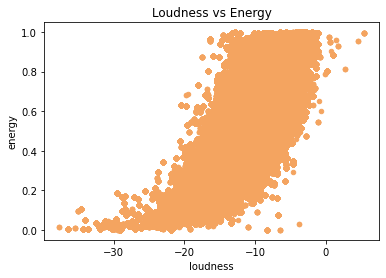

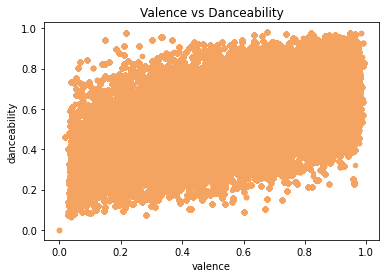

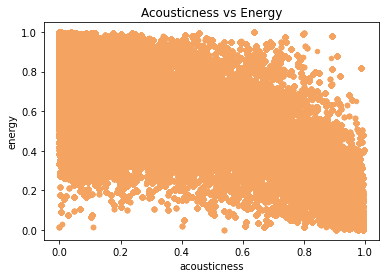

In [14]:
df.plot.scatter(x = 'loudness', y = 'energy',
                  color = 'sandybrown', title = 'Loudness vs Energy')
df.plot.scatter(x = 'valence', y = 'danceability',
                  color = 'sandybrown', title = 'Valence vs Danceability')
df.plot.scatter(x = 'acousticness', y = 'energy',
                  color = 'sandybrown', title = 'Acousticness vs Energy')

In [15]:
#create reference table of song id and its popularity
unique_indexes = df.song_id.drop_duplicates().index
df[['song_id','popularity']].loc[unique_indexes]
ref = df[['song_id','popularity']].loc[unique_indexes] #the ref table
ref.index = range(len(ref)) #make index as 0,1,...

In [16]:
#sum groupby song_id
df_pop = df[['song_id','listen_count']].groupby('song_id').sum()
df_pop.reset_index(inplace = True)
#order descending
df_pop.sort_values(by = ['listen_count'], ascending = False, inplace = True)
#merge
df_pop = df_pop.merge(ref, on = 'song_id')

In [17]:
df_pop.head()

,song_id,listen_count,popularity
0,SONYKOW12AB01849C9,292642,77
1,SODGVGW12AC9075A8D,221514,70
2,SOPXKYD12A6D4FA876,219132,86
3,SOFLJQZ12A6D4FADA6,185653,38
4,SONIQRE12AF72A2B02,182896,81


<AxesSubplot:title={'center':'Top 10 Songs by Listen Count'}, xlabel='song_id'>

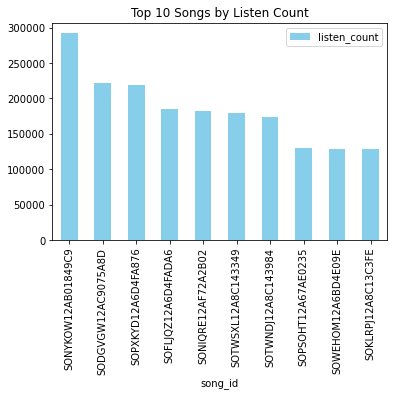

In [18]:
df_pop.iloc[:10].plot.bar(x = 'song_id', y = 'listen_count', 
                                 color = 'skyblue', 
                                 title = 'Top 10 Songs by Listen Count')